In [1]:
from google.colab import drive
drive.mount('../content/train')

# These codes are running in Google Colab. The drive must be assigned before running codes. 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ../content/train


In [5]:
from google.colab import files
uploaded = files.upload()

# Any necessary file must be loaded. If you are running in local machine, you can delete the codes and above. 

Saving expanded_seed.csv to expanded_seed.csv


In [0]:
from __future__ import print_function
from google.cloud import bigquery
import pandas as pd
import matplotlib.pylab as plt
from oauth2client.client import GoogleCredentials
from googleapiclient import discovery
import uuid
import time
from google.oauth2 import service_account
from pandas.io import gbq

In [0]:
# including files we customized
from data_preparation import data_preparation 
from word_extraction import text_cleaning
from seed_analysis import Visualization

In [0]:
# use the key json file from Google console to access the bigquery. 
# Index files for seed and antiseed must be uploaded to your own console first
# You can find those index files in the data folder
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./patent-158782975da6.json"
PROJECT_ID = "patent-241915"
DEST_DATASET = 'claims_analysis'

In [0]:
# Use the index files to extract abstracts for seed and antiseed
dp = data_preparation(PROJECT_ID, DEST_DATASET, 20000)
seed, antiseed = dp.load_seed(), dp.load_antiseed()

In [0]:
#seed = pd.read_csv('seed_abstract.csv')
#antiseed = pd.read_csv('antiseed_abstract.csv')

In [0]:
seed.head()

,publication_number,title,abstract
0,US-6652816-B2,Apparatus for generating ozone and anion,An apparatus for generating ozone and anion ca...
1,US-4655910-A,Liquid filtering device,"Liquid filter devices, particularly for irriga..."
2,US-3996136-A,Pump-filter for bilge water,A housing for a bilge pump-filter has a lower ...
3,US-6036178-A,Device for mixing air and water in a water pur...,A device for mixing air and water in a water p...
4,US-5813245-A,Pressure relief circuit for refrigerator conta...,A refrigerator having a water filtration and d...


In [0]:
antiseed.head()

,publication_number,title,abstract
0,US-9305610-B2,"Apparatus, system, and method for power reduct...","An apparatus, system, and method are disclosed..."
1,US-5612153-A,Battery mask from radiation curable and thermo...,"A secondary, solid electrolytic battery includ..."
2,US-3761533-A,Separation process of components of feed mixtu...,"A process for continuously separating, in the ..."
3,US-8480730-B2,Solid construct mitral spacer,A heart valve implant according to one embodim...
4,US-5014207-A,Solid imaging system,"In a solid imaging system, the beam of a relat..."


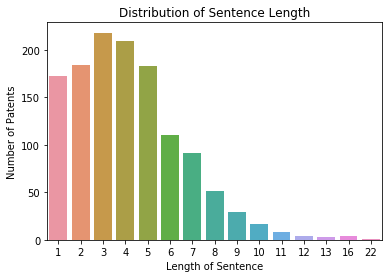

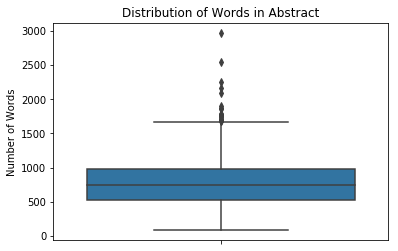

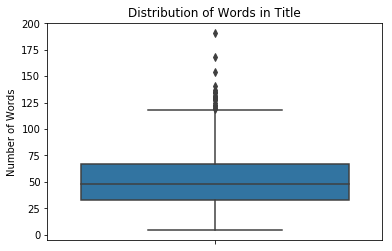

In [0]:
# Display the pictures on seed dataset
viz = Visualization(seed)
viz.number_viz()

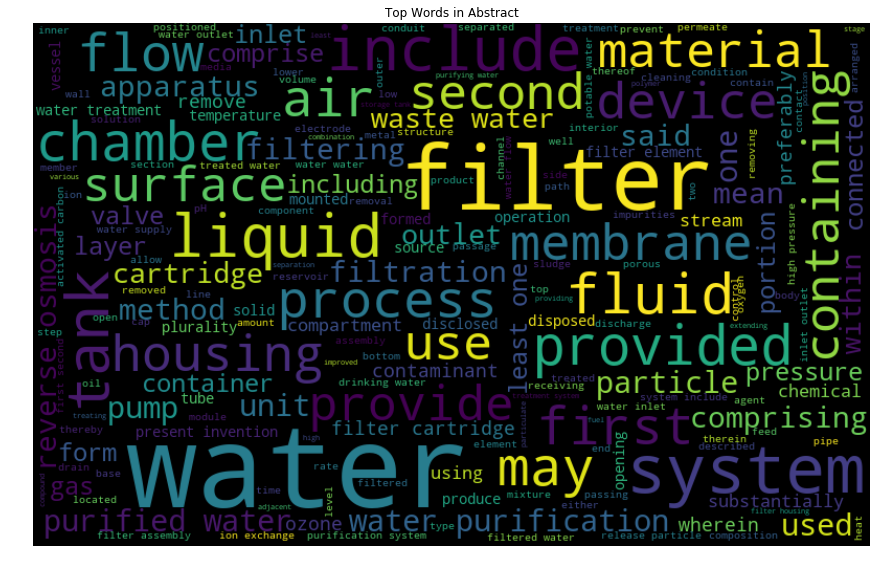

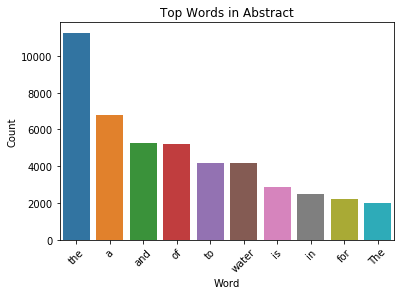

In [0]:
# some keywords
viz.words_abstract_viz('abstract')

In [0]:
# Display the clean texts on seed datasets
clean_seed = text_cleaning(seed)
seed = clean_seed.remove_stopword()
viz_clean = Visualization(seed)

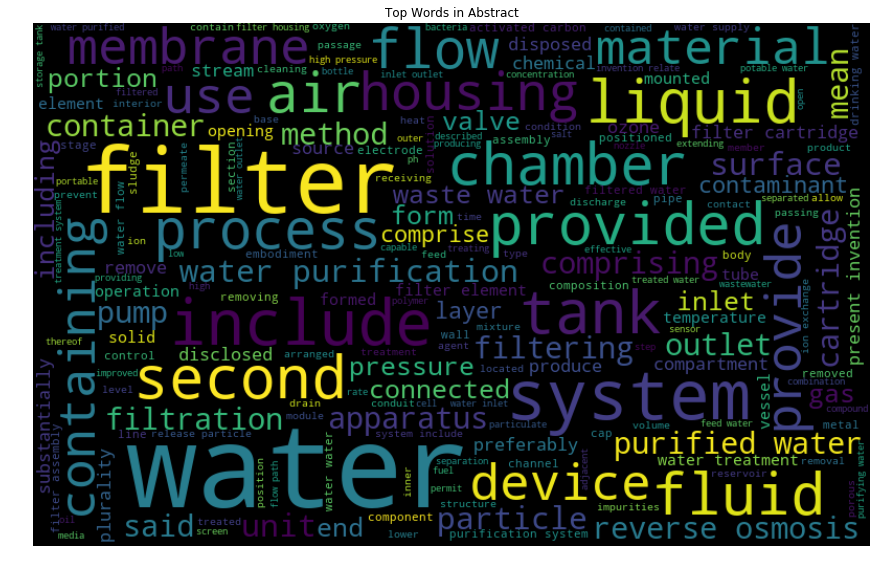

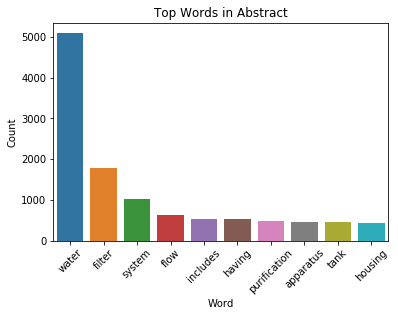

In [0]:
viz_clean.words_abstract_viz('abstract')

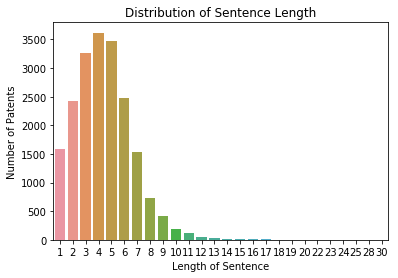

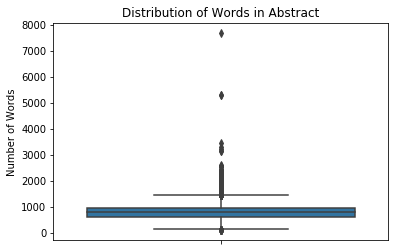

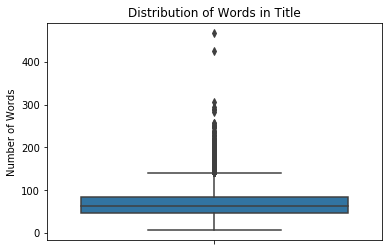

In [0]:
# Display antiseed datasets
viz_antiseed = Visualization(antiseed)
viz_antiseed.number_viz()

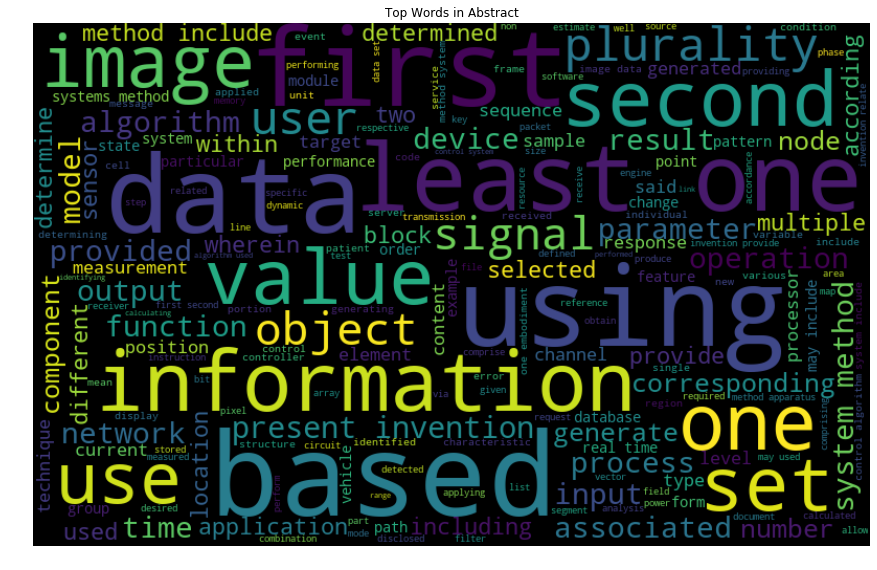

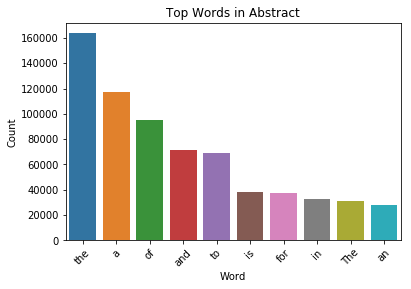

In [0]:
viz_antiseed.words_abstract_viz('abstract')

In [0]:
# Display the antiseed after cleaning abstract
clean_antiseed = text_cleaning(antiseed)
antiseed = clean_antiseed.remove_stopword()
viz_cln_anti = Visualization(antiseed)

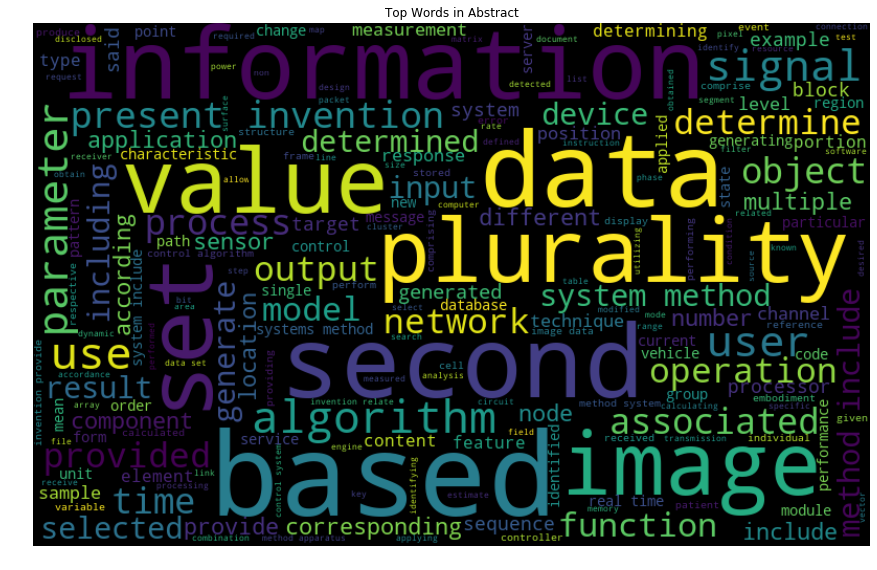

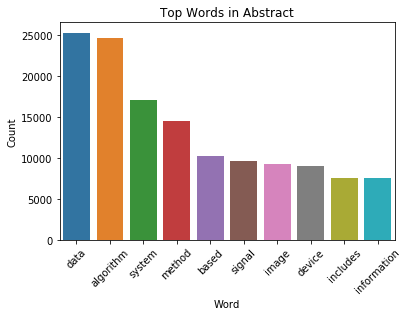

In [0]:
viz_cln_anti.words_abstract_viz('abstract')

In [0]:
# extract keywords from seed dataset and expanded the search results
keywords = clean_seed.key_words_tfidf('abstract')

These key words are ['water purification',
 'reverse osmosis',
 'purified water',
 'waste water',
 'filter cartridge',
 'present invention',
 'water treatment',
 'water filter',
 'filter assembly',
 'purification system']

In [0]:
# Use the keywords to find relevant patents and compose as dataframe
expanded_patent = dp.load_expanded(keywords)


In [0]:
expanded_patent = pd.read_csv('expanded_seed.csv', compression='gzip')

In [0]:
expanded = Visualization(expanded_patent)

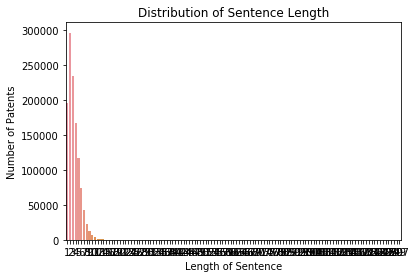

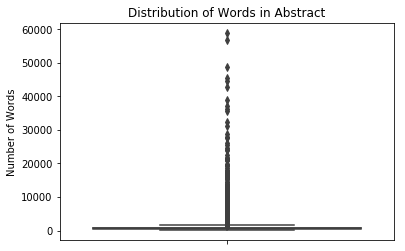

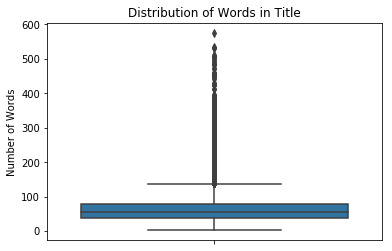

In [27]:
expanded.number_viz()

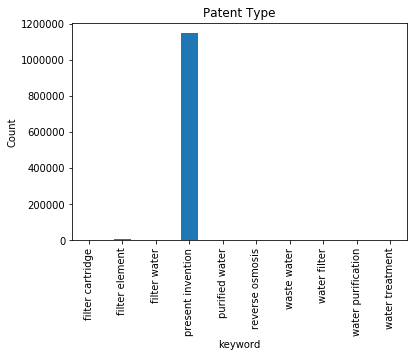

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Display the unbalanced datasets of expanded datasets
ep= expanded_patent.groupby('keyword')['keyword'].count()
ep.plot(kind='bar')
plt.ylabel('Count')
plt.title('Patent Type')
plt.show()

In [0]:
# Select random 500000 patents from patents with "present invention"
df_sub = expanded_patent[expanded_patent['keyword'] == 'present invention'].sample(500000)
df_other = expanded_patent[expanded_patent['keyword'] != 'present invention']
df_sub = pd.concat([df_sub, df_other], ignore_index=True)